In [1]:
# Cell 1: Imports and Setup
from google.cloud import bigquery
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import time

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

client = bigquery.Client(project="students-group2")

print("✅ Imports successful!")

✅ Imports successful!


In [2]:
# Cell 2: Load Data
print("Loading data from BigQuery...")

# Load ratings
query_ratings = """
SELECT userId, movieId, rating
FROM `master-ai-cloud.MoviePlatform.ratings`
"""
df_ratings = client.query(query_ratings).to_dataframe()
print(f"✓ Loaded {len(df_ratings):,} ratings")

# Load movies
query_movies = """
SELECT movieId, title, genres
FROM `master-ai-cloud.MoviePlatform.movies`
"""
df_movies = client.query(query_movies).to_dataframe()
print(f"✓ Loaded {len(df_movies):,} movies")

# Create train/test split (same split for both models)
train_df, test_df = train_test_split(df_ratings, test_size=0.2, random_state=42)
print(f"✓ Train: {len(train_df):,} ratings, Test: {len(test_df):,} ratings")

# Create user-item matrix (needed for both models)
user_item_matrix = train_df.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)
print(f"✓ User-item matrix: {user_item_matrix.shape}")

Loading data from BigQuery...
✓ Loaded 105,339 ratings
✓ Loaded 10,329 movies
✓ Train: 84,271 ratings, Test: 21,068 ratings
✓ User-item matrix: (668, 9565)


In [3]:
# Cell 2.5: Find Your Model Files
import os
import subprocess

print("=" * 70)
print("LOCATING MODEL FILES")
print("=" * 70)

# Check current directory
print(f"\nCurrent working directory: {os.getcwd()}")

# Try the relative path first
relative_path = 'OubeidAllah_Ghassen/AI_On_The_Cloud/Ghassens_models'
if os.path.exists(relative_path):
    print(f"✅ Found models at relative path: {relative_path}")
    svd_model_dir = relative_path
else:
    print(f"❌ Relative path not found: {relative_path}")
    
    # Search for the folder
    print("\n🔍 Searching for Ghassens_models folder...")
    result = subprocess.run(
        ['find', '/home/jupyter', '-name', 'Ghassens_models', '-type', 'd'],
        capture_output=True,
        text=True
    )
    
    if result.stdout:
        found_paths = result.stdout.strip().split('\n')
        print(f"✅ Found {len(found_paths)} location(s):")
        for path in found_paths:
            print(f"   {path}")
            # Check if it has the model files
            if os.path.exists(os.path.join(path, 'U.pkl')):
                svd_model_dir = path
                print(f"   ✅ This one has model files!")
        
        if 'svd_model_dir' not in locals():
            svd_model_dir = found_paths[0]
    else:
        print("❌ Could not find Ghassens_models folder")
        print("\nPlease run your model training notebook (03_matrix_factorization_model.ipynb)")
        print("and save the model first!")
        raise FileNotFoundError("Model files not found. Please train and save the model first.")

# Verify the files exist
print(f"\n📂 Using model directory: {svd_model_dir}")
print(f"📍 Absolute path: {os.path.abspath(svd_model_dir)}")

required_files = ['U.pkl', 'sigma.pkl', 'Vt.pkl', 'user_means.pkl', 'movie_ids.pkl', 'movies_metadata.pkl']
print("\n✓ Checking for required files:")
for file in required_files:
    filepath = os.path.join(svd_model_dir, file)
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"   ✅ {file:<25} ({size_mb:.2f} MB)")
    else:
        print(f"   ❌ {file:<25} MISSING!")

print("\n" + "=" * 70)

LOCATING MODEL FILES

Current working directory: /home/jupyter/OubeidAllah_Ghassen/AI_On_The_Cloud/notebooks
✅ Found models at relative path: OubeidAllah_Ghassen/AI_On_The_Cloud/Ghassens_models

📂 Using model directory: OubeidAllah_Ghassen/AI_On_The_Cloud/Ghassens_models
📍 Absolute path: /home/jupyter/OubeidAllah_Ghassen/AI_On_The_Cloud/notebooks/OubeidAllah_Ghassen/AI_On_The_Cloud/Ghassens_models

✓ Checking for required files:
   ✅ U.pkl                     (0.25 MB)
   ✅ sigma.pkl                 (0.02 MB)
   ✅ Vt.pkl                    (3.65 MB)
   ✅ user_means.pkl            (0.01 MB)
   ✅ movie_ids.pkl             (0.03 MB)
   ✅ movies_metadata.pkl       (0.44 MB)



In [4]:
# Cell 3: Load SVD Model (FIXED)
print("=" * 70)
print("LOADING SVD MATRIX FACTORIZATION MODEL")
print("=" * 70)

# svd_model_dir is already set by Cell 2.5
print(f"Loading from: {svd_model_dir}")

# Load SVD components
try:
    with open(os.path.join(svd_model_dir, 'U.pkl'), 'rb') as f:
        U = pickle.load(f)
    print(f"✓ Loaded U matrix: {U.shape}")

    with open(os.path.join(svd_model_dir, 'sigma.pkl'), 'rb') as f:
        sigma = pickle.load(f)
    print(f"✓ Loaded Sigma matrix: {sigma.shape}")

    with open(os.path.join(svd_model_dir, 'Vt.pkl'), 'rb') as f:
        Vt = pickle.load(f)
    print(f"✓ Loaded Vt matrix: {Vt.shape}")

    with open(os.path.join(svd_model_dir, 'user_means.pkl'), 'rb') as f:
        user_means_svd = pickle.load(f)
    print(f"✓ Loaded user means: {len(user_means_svd)}")

except FileNotFoundError as e:
    print(f"\n❌ ERROR: Could not load model files!")
    print(f"Missing file: {e}")
    print("\n💡 Solution:")
    print("1. Go to your 03_matrix_factorization_model.ipynb notebook")
    print("2. Run all cells to train the model")
    print("3. Run the save cell (Cell 10) to save model files")
    print("4. Then come back and run this comparison notebook")
    raise

# Define SVD prediction function
def predict_svd(U, sigma, Vt, user_means, train_matrix):
    """Generate predictions using SVD"""
    R_pred = U @ sigma @ Vt + user_means.reshape(-1, 1)
    R_pred = np.clip(R_pred, 0.5, 5.0)
    return pd.DataFrame(R_pred, index=train_matrix.index, columns=train_matrix.columns)

# Generate predictions
print("\nGenerating predictions...")
svd_predictions = predict_svd(U, sigma, Vt, user_means_svd, user_item_matrix)
print(f"✓ SVD predictions generated: {svd_predictions.shape}")

LOADING SVD MATRIX FACTORIZATION MODEL
Loading from: OubeidAllah_Ghassen/AI_On_The_Cloud/Ghassens_models
✓ Loaded U matrix: (668, 50)
✓ Loaded Sigma matrix: (50, 50)
✓ Loaded Vt matrix: (50, 9565)
✓ Loaded user means: 668

Generating predictions...
✓ SVD predictions generated: (668, 9565)


In [5]:
# Cell 4: Load/Compute Item-Similarity Model
print("=" * 70)
print("LOADING ITEM-BASED COLLABORATIVE FILTERING MODEL")
print("=" * 70)

# Try to load pre-computed similarity matrix
item_sim_model_dir = '../models/item_similarity_2'  # Adjust this path

try:
    with open(os.path.join(item_sim_model_dir, 'item_similarity_with_confidence_weighting.pkl'), 'rb') as f:
        item_similarity_df = pickle.load(f)
    print(f"✓ Loaded item similarity matrix: {item_similarity_df.shape}")
except FileNotFoundError:
    print("⚠️  Pre-trained item similarity not found. Computing from scratch...")
    from sklearn.metrics.pairwise import cosine_similarity
    
    item_matrix = user_item_matrix.T
    item_similarity = cosine_similarity(item_matrix)
    item_similarity_df = pd.DataFrame(
        item_similarity,
        index=item_matrix.index,
        columns=item_matrix.index
    )
    print(f"✓ Computed item similarity matrix: {item_similarity_df.shape}")

# Define item-similarity prediction function
def predict_item_similarity(user_id, movie_id, user_item_matrix, item_similarity_df, k=50):
    """
    Predict rating for a user-movie pair using item-based CF
    """
    if user_id not in user_item_matrix.index:
        return 3.5
    
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0]
    
    if len(rated_movies) == 0:
        return 3.5
    
    if movie_id not in item_similarity_df.index:
        return rated_movies.mean()
    
    similarities = item_similarity_df[movie_id]
    relevant_similarities = similarities[rated_movies.index]
    top_k = relevant_similarities.nlargest(min(k, len(relevant_similarities)))
    
    if top_k.sum() == 0:
        return rated_movies.mean()
    
    weighted_sum = sum(top_k[mid] * rated_movies[mid] for mid in top_k.index)
    prediction = weighted_sum / top_k.sum()
    
    return np.clip(prediction, 0.5, 5.0)

print("✓ Item-similarity prediction function loaded")

LOADING ITEM-BASED COLLABORATIVE FILTERING MODEL
✓ Loaded item similarity matrix: (10325, 10325)
✓ Item-similarity prediction function loaded


In [6]:
# Cell 5: Evaluate Both Models
print("=" * 70)
print("EVALUATING PREDICTION ACCURACY")
print("=" * 70)

# Evaluate SVD
print("\n1️⃣  Evaluating SVD Matrix Factorization...")
svd_test_preds = []
svd_test_actuals = []
svd_start = time.time()

for idx, row in test_df.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    actual = row['rating']
    
    if user_id in svd_predictions.index and movie_id in svd_predictions.columns:
        pred = svd_predictions.loc[user_id, movie_id]
        svd_test_preds.append(pred)
        svd_test_actuals.append(actual)

svd_time = time.time() - svd_start

svd_rmse = np.sqrt(mean_squared_error(svd_test_actuals, svd_test_preds))
svd_mae = mean_absolute_error(svd_test_actuals, svd_test_preds)

print(f"  Samples evaluated: {len(svd_test_preds):,}")
print(f"  RMSE: {svd_rmse:.4f}")
print(f"  MAE:  {svd_mae:.4f}")
print(f"  Time: {svd_time:.2f}s")

# Evaluate Item Similarity
print("\n2️⃣  Evaluating Item-Based Collaborative Filtering...")
item_test_preds = []
item_test_actuals = []
item_start = time.time()

# Sample for faster evaluation
test_sample = test_df.sample(min(5000, len(test_df)), random_state=42)

for idx, row in test_sample.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    actual = row['rating']
    
    pred = predict_item_similarity(user_id, movie_id, user_item_matrix, item_similarity_df, k=50)
    item_test_preds.append(pred)
    item_test_actuals.append(actual)

item_time = time.time() - item_start

item_rmse = np.sqrt(mean_squared_error(item_test_actuals, item_test_preds))
item_mae = mean_absolute_error(item_test_actuals, item_test_preds)

print(f"  Samples evaluated: {len(item_test_preds):,}")
print(f"  RMSE: {item_rmse:.4f}")
print(f"  MAE:  {item_mae:.4f}")
print(f"  Time: {item_time:.2f}s")

# Baseline
print("\n3️⃣  Baseline (Always predict average)...")
baseline_pred = df_ratings['rating'].mean()
baseline_preds = [baseline_pred] * len(svd_test_actuals)
baseline_rmse = np.sqrt(mean_squared_error(svd_test_actuals, baseline_preds))
baseline_mae = mean_absolute_error(svd_test_actuals, baseline_preds)

print(f"  Baseline prediction: {baseline_pred:.2f}")
print(f"  RMSE: {baseline_rmse:.4f}")
print(f"  MAE:  {baseline_mae:.4f}")

EVALUATING PREDICTION ACCURACY

1️⃣  Evaluating SVD Matrix Factorization...
  Samples evaluated: 20,239
  RMSE: 0.9208
  MAE:  0.7117
  Time: 2.19s

2️⃣  Evaluating Item-Based Collaborative Filtering...
  Samples evaluated: 5,000
  RMSE: 0.8786
  MAE:  0.6706
  Time: 13.33s

3️⃣  Baseline (Always predict average)...
  Baseline prediction: 3.52
  RMSE: 1.0441
  MAE:  0.8340


In [7]:
# Cell 6: Comparison Summary
print("\n" + "=" * 70)
print("PREDICTION ACCURACY COMPARISON")
print("=" * 70)

# Calculate accuracy percentages
svd_errors = np.abs(np.array(svd_test_preds) - np.array(svd_test_actuals))
svd_within_half = (svd_errors <= 0.5).sum() / len(svd_errors) * 100
svd_within_one = (svd_errors <= 1.0).sum() / len(svd_errors) * 100

item_errors = np.abs(np.array(item_test_preds) - np.array(item_test_actuals))
item_within_half = (item_errors <= 0.5).sum() / len(item_errors) * 100
item_within_one = (item_errors <= 1.0).sum() / len(item_errors) * 100

# Create comparison table
comparison_data = {
    'Model': [
        'Baseline (Average)',
        'Item-Based CF',
        'SVD Matrix Factorization'
    ],
    'RMSE': [
        f"{baseline_rmse:.4f}",
        f"{item_rmse:.4f}",
        f"{svd_rmse:.4f}"
    ],
    'MAE': [
        f"{baseline_mae:.4f}",
        f"{item_mae:.4f}",
        f"{svd_mae:.4f}"
    ],
    'Within ±0.5★': [
        'N/A',
        f"{item_within_half:.1f}%",
        f"{svd_within_half:.1f}%"
    ],
    'Within ±1.0★': [
        'N/A',
        f"{item_within_one:.1f}%",
        f"{svd_within_one:.1f}%"
    ],
    'Time (s)': [
        '< 0.01',
        f"{item_time:.2f}",
        f"{svd_time:.2f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Winner analysis
print("\n" + "=" * 70)
print("🏆 WINNER ANALYSIS")
print("=" * 70)

if svd_rmse < item_rmse:
    improvement = (item_rmse - svd_rmse) / item_rmse * 100
    print(f"✅ SVD Matrix Factorization WINS!")
    print(f"   RMSE improvement: {improvement:.1f}% better than Item-Based CF")
else:
    improvement = (svd_rmse - item_rmse) / svd_rmse * 100
    print(f"✅ Item-Based Collaborative Filtering WINS!")
    print(f"   RMSE improvement: {improvement:.1f}% better than SVD")

print(f"\n   Both models beat baseline (RMSE={baseline_rmse:.4f})")
print(f"   SVD beats baseline by: {(baseline_rmse - svd_rmse)/baseline_rmse*100:.1f}%")
print(f"   Item-CF beats baseline by: {(baseline_rmse - item_rmse)/baseline_rmse*100:.1f}%")


PREDICTION ACCURACY COMPARISON

                   Model   RMSE    MAE Within ±0.5★ Within ±1.0★ Time (s)
      Baseline (Average) 1.0441 0.8340          N/A          N/A   < 0.01
           Item-Based CF 0.8786 0.6706        47.0%        78.3%    13.33
SVD Matrix Factorization 0.9208 0.7117        43.9%        74.8%     2.19

🏆 WINNER ANALYSIS
✅ Item-Based Collaborative Filtering WINS!
   RMSE improvement: 4.6% better than SVD

   Both models beat baseline (RMSE=1.0441)
   SVD beats baseline by: 11.8%
   Item-CF beats baseline by: 15.9%


Generating comparison visualizations...


/var/tmp/ipykernel_74039/2776325925.py:106: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/tmp/ipykernel_74039/2776325925.py:107: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('model_comparison_comprehensive.png', dpi=150, bbox_inches='tight')



✅ Saved: model_comparison_comprehensive.png


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


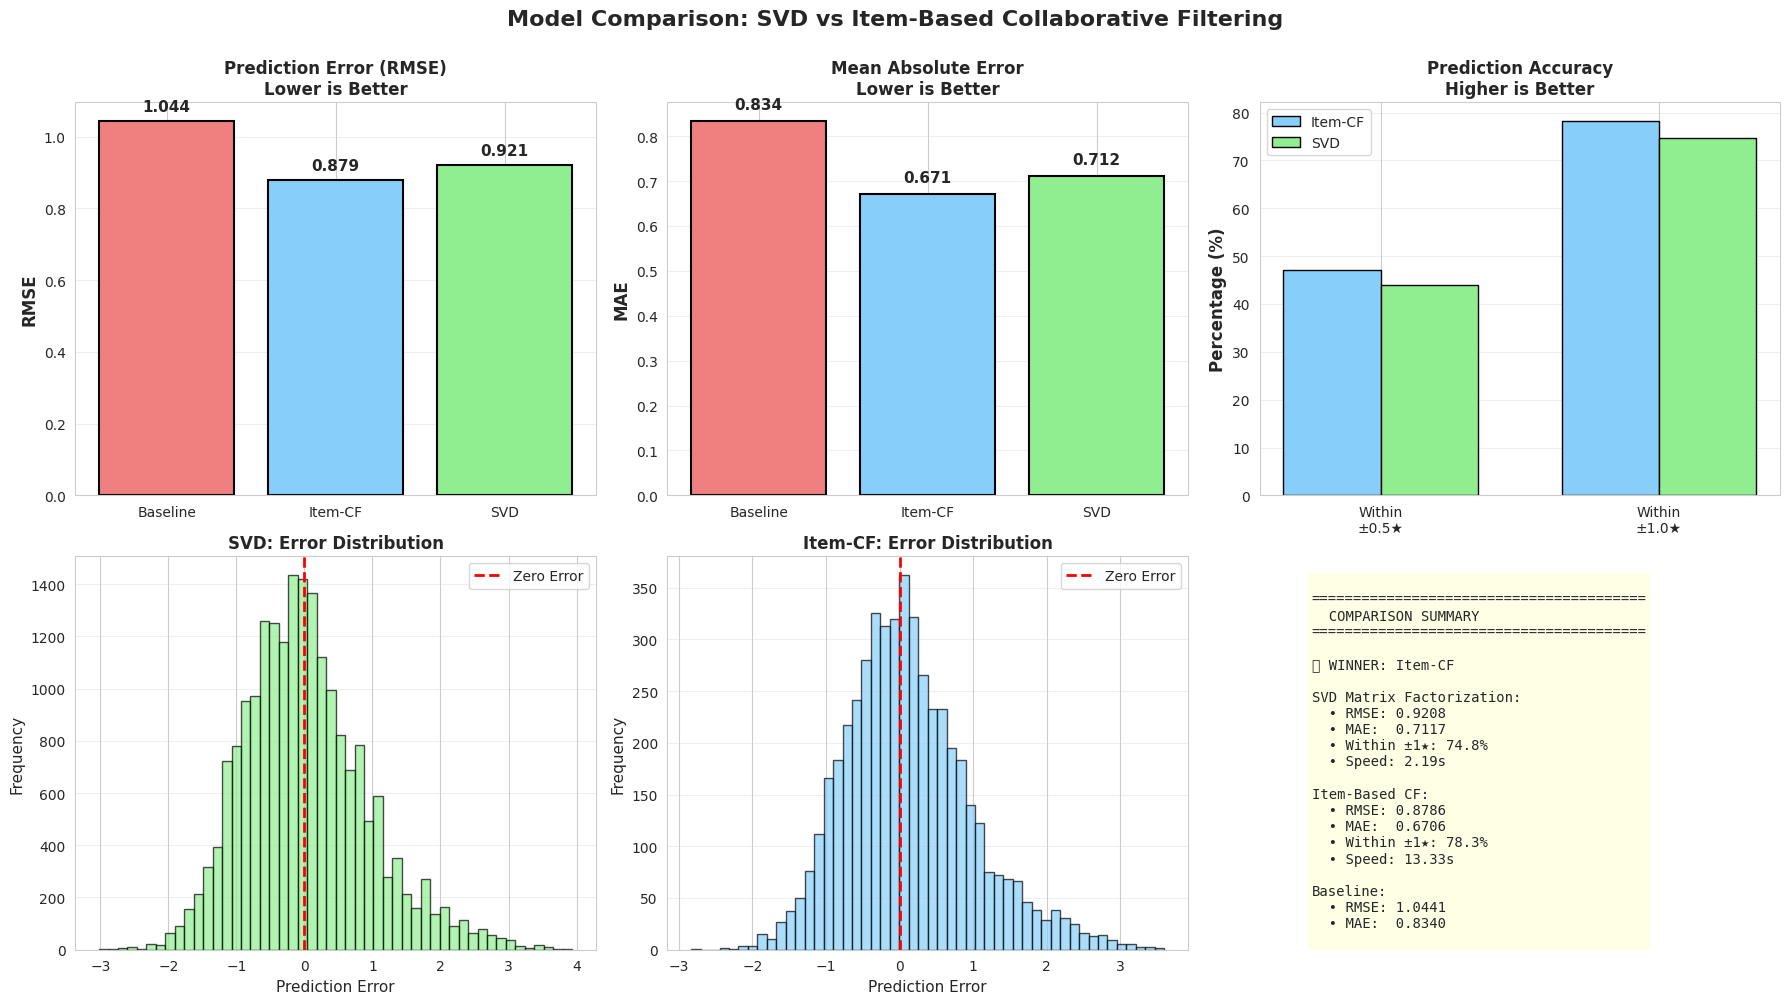

In [8]:
# Cell 7: Comprehensive Visualization
print("Generating comparison visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Comparison: SVD vs Item-Based Collaborative Filtering', 
             fontsize=16, fontweight='bold', y=1.00)

# 1. RMSE Comparison
ax1 = axes[0, 0]
models = ['Baseline', 'Item-CF', 'SVD']
rmse_vals = [baseline_rmse, item_rmse, svd_rmse]
colors = ['lightcoral', 'lightskyblue', 'lightgreen']
bars = ax1.bar(models, rmse_vals, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax1.set_title('Prediction Error (RMSE)\nLower is Better', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, rmse_vals):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. MAE Comparison
ax2 = axes[0, 1]
mae_vals = [baseline_mae, item_mae, svd_mae]
bars2 = ax2.bar(models, mae_vals, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('MAE', fontsize=12, fontweight='bold')
ax2.set_title('Mean Absolute Error\nLower is Better', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, mae_vals):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Accuracy Breakdown
ax3 = axes[0, 2]
categories = ['Within\n±0.5★', 'Within\n±1.0★']
item_acc = [item_within_half, item_within_one]
svd_acc = [svd_within_half, svd_within_one]
x = np.arange(len(categories))
width = 0.35
ax3.bar(x - width/2, item_acc, width, label='Item-CF', color='lightskyblue', edgecolor='black')
ax3.bar(x + width/2, svd_acc, width, label='SVD', color='lightgreen', edgecolor='black')
ax3.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax3.set_title('Prediction Accuracy\nHigher is Better', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(categories)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 4. SVD Error Distribution
ax4 = axes[1, 0]
svd_error_vals = np.array(svd_test_preds) - np.array(svd_test_actuals)
ax4.hist(svd_error_vals, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax4.set_xlabel('Prediction Error', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('SVD: Error Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Item-CF Error Distribution
ax5 = axes[1, 1]
item_error_vals = np.array(item_test_preds) - np.array(item_test_actuals)
ax5.hist(item_error_vals, bins=50, color='lightskyblue', edgecolor='black', alpha=0.7)
ax5.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax5.set_xlabel('Prediction Error', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.set_title('Item-CF: Error Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Summary Statistics
ax6 = axes[1, 2]
ax6.axis('off')

winner = 'SVD' if svd_rmse < item_rmse else 'Item-CF'

summary = f"""
{'='*40}
  COMPARISON SUMMARY
{'='*40}

🏆 WINNER: {winner}

SVD Matrix Factorization:
  • RMSE: {svd_rmse:.4f}
  • MAE:  {svd_mae:.4f}
  • Within ±1★: {svd_within_one:.1f}%
  • Speed: {svd_time:.2f}s

Item-Based CF:
  • RMSE: {item_rmse:.4f}
  • MAE:  {item_mae:.4f}
  • Within ±1★: {item_within_one:.1f}%
  • Speed: {item_time:.2f}s

Baseline:
  • RMSE: {baseline_rmse:.4f}
  • MAE:  {baseline_mae:.4f}
"""

ax6.text(0.1, 0.95, summary, transform=ax6.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('model_comparison_comprehensive.png', dpi=150, bbox_inches='tight')
print("\n✅ Saved: model_comparison_comprehensive.png")
plt.show()